In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
import keras
import matplotlib.pyplot as plt
import numpy as np

2024-12-09 18:26:46.096076: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 18:26:46.098727: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 18:26:46.106868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733761606.120188   82540 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733761606.123955   82540 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 18:26:46.137769: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [23]:
dataset = loadmat('../data/shuttle.mat')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(dataset['X'], dataset['y'], train_size=0.5)

In [29]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24548, 9) (24549, 9) (24548, 1) (24549, 1)


In [4]:
contamination_rate = y_train.sum() / len(y_train)

In [5]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
class AutoEncoder(keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = keras.Sequential([
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(5, activation='relu'),
            keras.layers.Dense(3, activation='relu')
        ])
        self.decoder = keras.Sequential([
            keras.layers.Dense(5, activation='relu'),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(9, activation='sigmoid')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
model = AutoEncoder()
model.compile(optimizer='adam', loss='mse')

W0000 00:00:1733761612.742800   82540 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2468 - val_loss: 0.2367
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2321 - val_loss: 0.2143
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2073 - val_loss: 0.1854
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1795 - val_loss: 0.1598
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1539 - val_loss: 0.1354
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1300 - val_loss: 0.1119
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1047 - val_loss: 0.0906
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0850 - val_loss: 0.0748
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0741 - val_loss: 0.0664
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0657 - val_loss: 0.0612
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0589 - val_loss: 0.0555
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

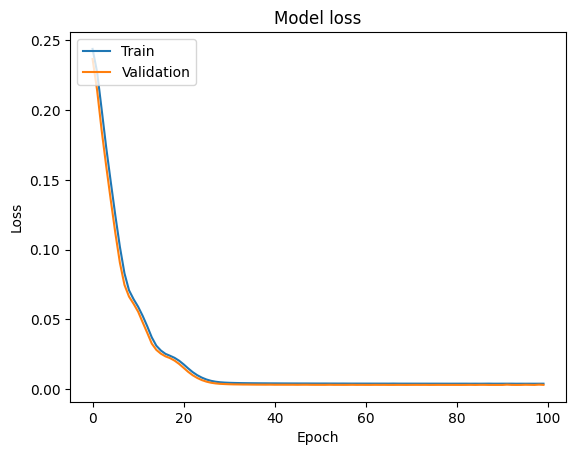

In [8]:
model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=1024,
    validation_data=(X_test, y_test)
)

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

    

In [40]:
def reconstruction_error(data):
    scores = model.predict(data)
    reconstruction_errors = []
    for i in range(len(data)):
        reconstruction_errors.append(np.mean((data[i] - scores[i])**2))
    return np.array(reconstruction_errors)

In [41]:
re_train = reconstruction_error(X_train)
re_test = reconstruction_error(X_test)

768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step


In [42]:
threshold = np.quantile(re_train, 1 - contamination_rate)

In [45]:
contamination_rate, threshold

(np.float64(0.07202216066481995), np.float32(2814.6748))

In [44]:
# classify using the threshold
y_pred_train = (re_train > threshold).astype(int)
y_pred_test = (re_test > threshold).astype(int)

# calculate the balanced accuracy
balanced_accuracy_train = balanced_accuracy_score(y_train, y_pred_train)
balanced_accuracy_test = balanced_accuracy_score(y_test, y_pred_test)

print(f'Balanced accuracy on train set: {balanced_accuracy_train}')
print(f'Balanced accuracy on test set: {balanced_accuracy_test}')

Balanced accuracy on train set: 0.9783341561715024
Balanced accuracy on test set: 0.9795188066874734
